<a href="https://colab.research.google.com/github/lifewinning/MLTSA22_IBurrington/blob/main/HW3/IB_HW3_ARIMA_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import json
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


loading HW2 cause that is where the data is, even if this is HW3

In [ ]:
cd /content/gdrive/MyDrive/MLTSA22/HW2

/content/gdrive/MyDrive/MLTSA22/HW2


# Part 1: data ingestion, exploration, preparation 
#...continuing on from HW2... 
you can start with the HW2 notebook you created or my solution which is in https://github.com/fedhere/MLTSA22_FBianco/tree/main/HW2


In [ ]:
allfiles = np.sort(np.array(glob.glob("Data/Stocks/*.txt")))[:10]
tss = pd.read_csv(allfiles[0])[["Date", "Close"]].rename({"Close":
              allfiles[0].replace(".txt",
                                  "").replace("Data/Stocks/", 
                                              "")}, axis=1)
for f in allfiles[1:]:
    print(f)
    name = f.replace(".txt","").replace("Data/Stocks/", "")
    
    tss = tss.merge(pd.read_csv(f)[["Date", "Close"]].rename({"Close":
                                                              name}, 
                                        axis=1), on="Date")
tss.set_index("Date", inplace=True)

Data/Stocks/aa.us.txt
Data/Stocks/aaap.us.txt
Data/Stocks/aaba.us.txt
Data/Stocks/aac.us.txt
Data/Stocks/aal.us.txt
Data/Stocks/aamc.us.txt
Data/Stocks/aame.us.txt
Data/Stocks/aan.us.txt
Data/Stocks/aaoi.us.txt


## testing for stationarity (you did it in HW2 but it will be useful have it here under your eyes)
test if each of these time series is stationary using the AD fuller test using ```statsmodels.api.tsa.stattools.adfuller()```

```for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

In [ ]:
threshold = 0.05
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
for c in tss.columns:
    print(c, "is stationary:", sm.tsa.stattools.adfuller(tss[c])[1] < threshold)

Stationarity results from the AD Fuller test at a p-value of 0.05
a.us is stationary: False
aa.us is stationary: False
aaap.us is stationary: False
aaba.us is stationary: False
aac.us is stationary: False
aal.us is stationary: False
aamc.us is stationary: False
aame.us is stationary: True
aan.us is stationary: False
aaoi.us is stationary: False


# 1. Question: why did I set the threshold to 0.05? what does 0.05 mean? 

0.05 refers to the p-value (probability) of the null hypothesis that establishes stationarity; it also is another way of describing the probability of events beyond 2 x standard deviation in a normal distribution (so, something that is only 5% likely to occur in the distribution). Basically the threshold means we're only considering something as likely stationary if its p-value is very unlikely in a normal distribution.

<font color="red"> FBB:good</font>

# 2. Task: measure autocorrelation

plot the time series and its autocorrelation and partial autocorrelation function in blue if it is not stationary, in red if it is stationary

As a reminder, the plotting function for the autocorrelation and partial autocorelation functions works as follows

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


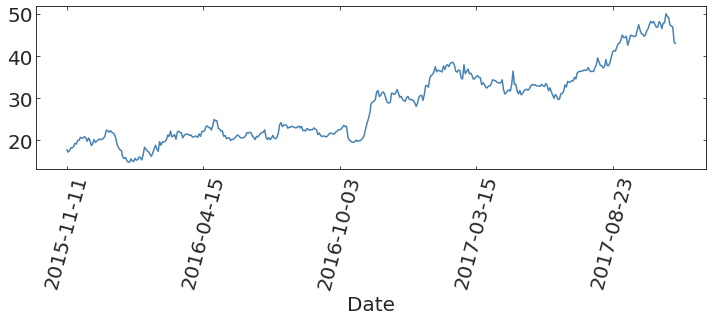

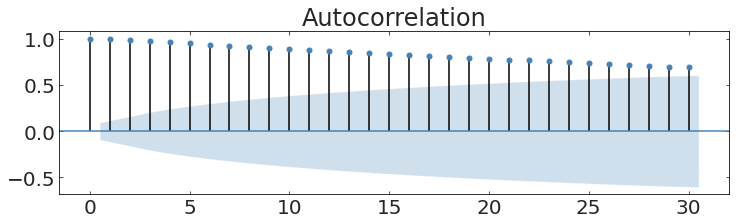

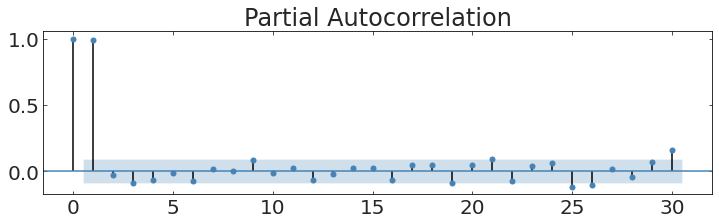

In [ ]:
tss["aa.us"].plot(rot=75, figsize=(12,3));
ax = pl.figure(figsize=(12,3)).add_subplot(111)
sm.graphics.tsa.plot_acf(tss["aa.us"], lags=30, ax=ax)
ax = pl.figure(figsize=(12,3)).add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(tss["aa.us"], lags=30, ax=ax);

<font color="red"> FBB:all figures should have captions!!</font>

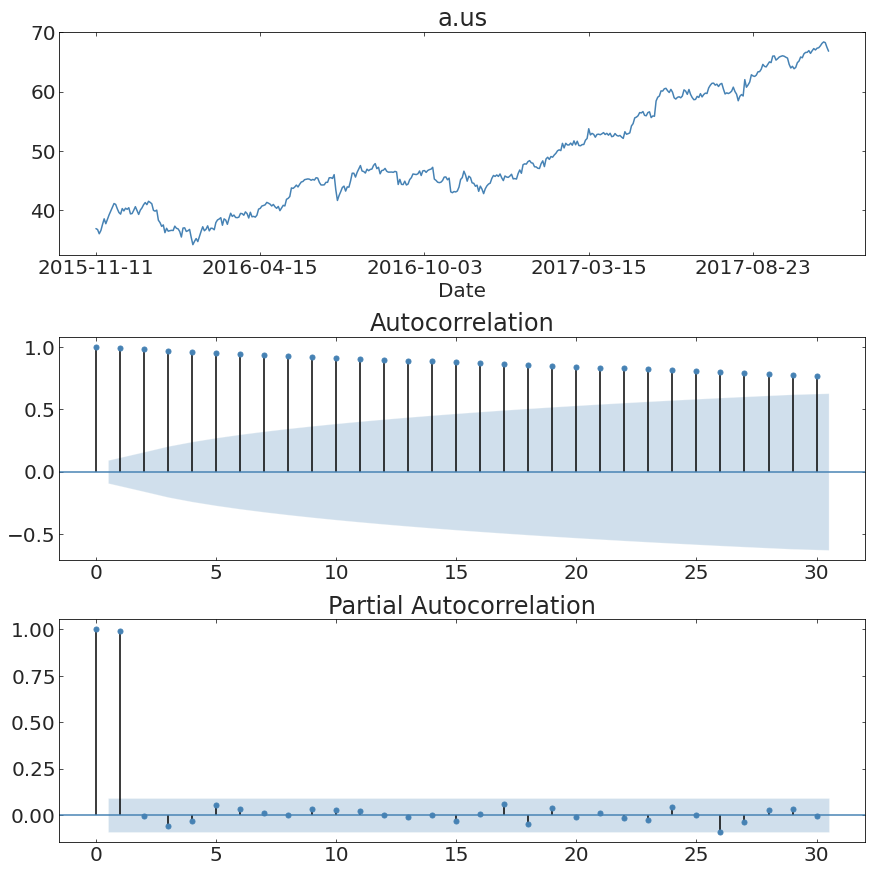

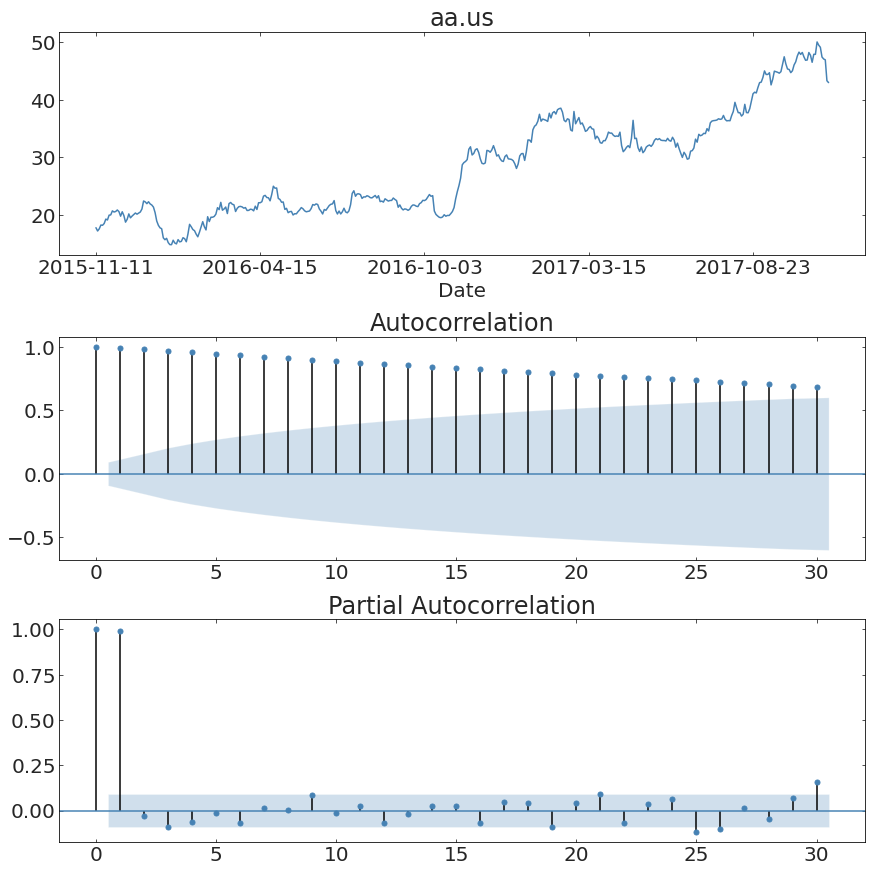

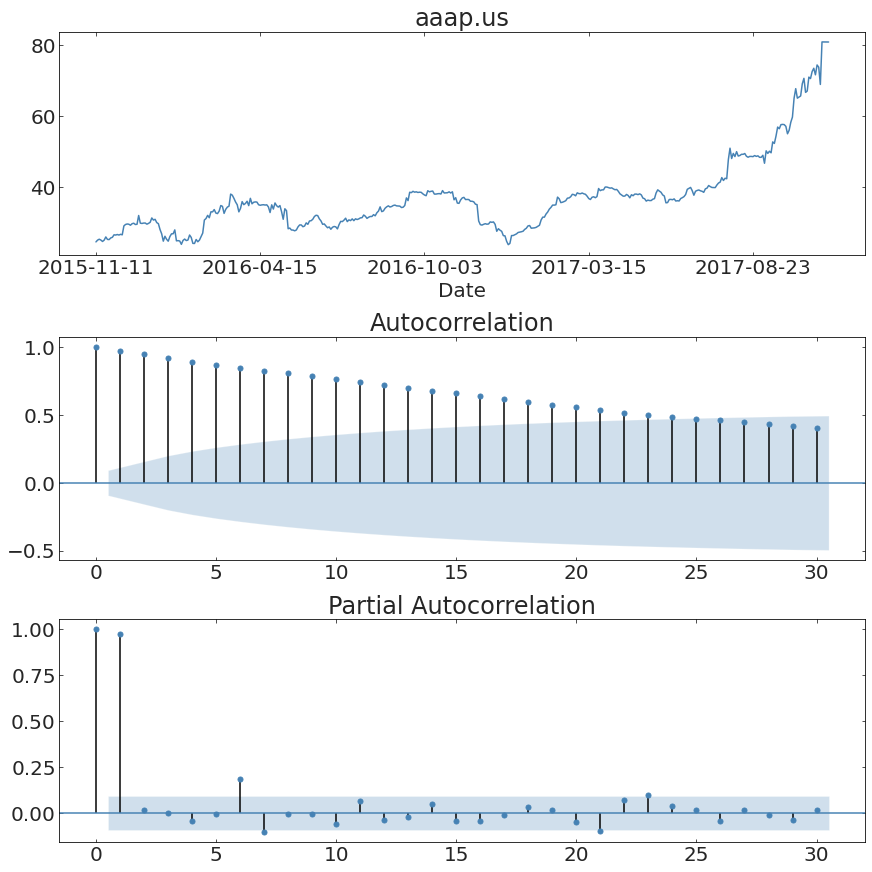

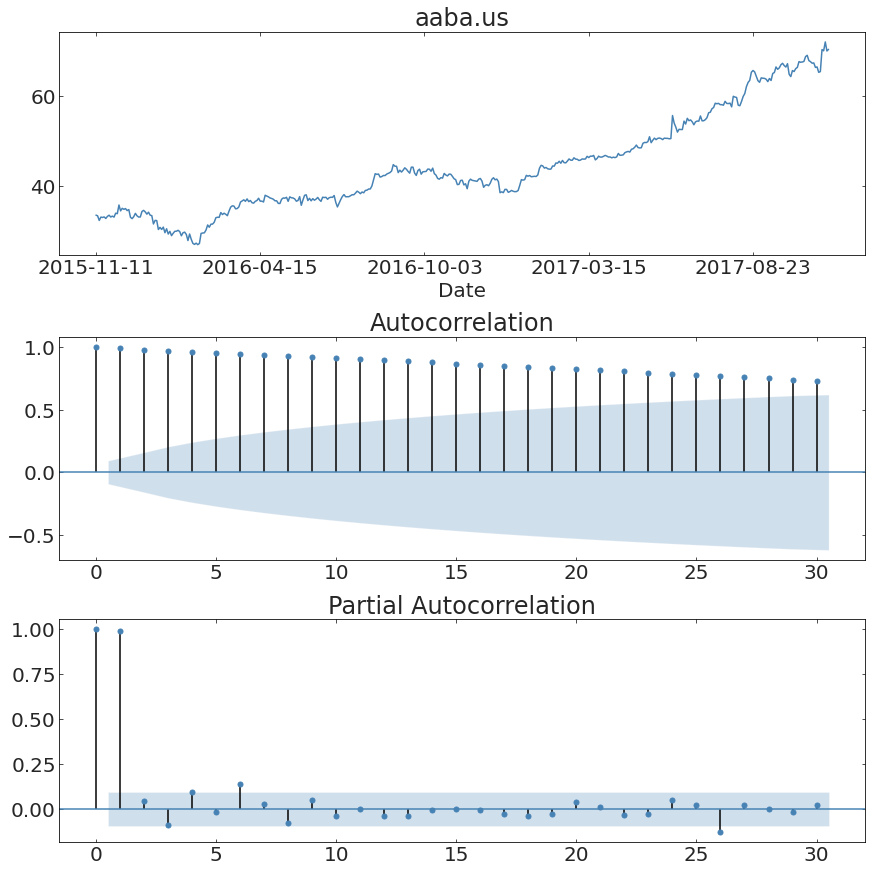

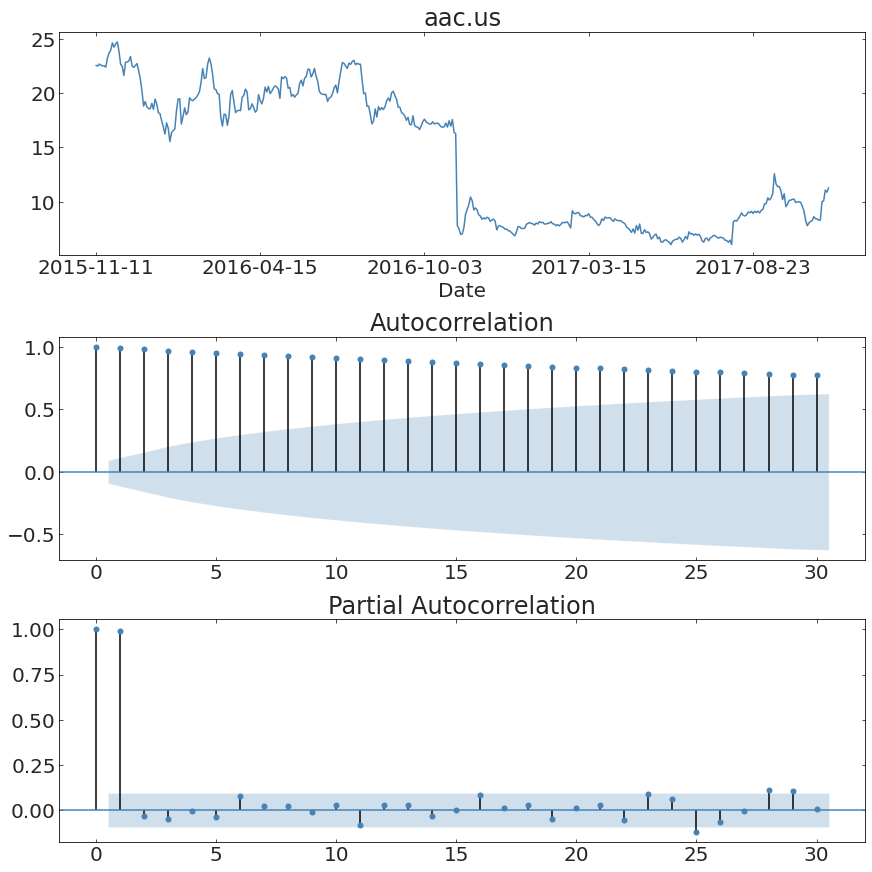

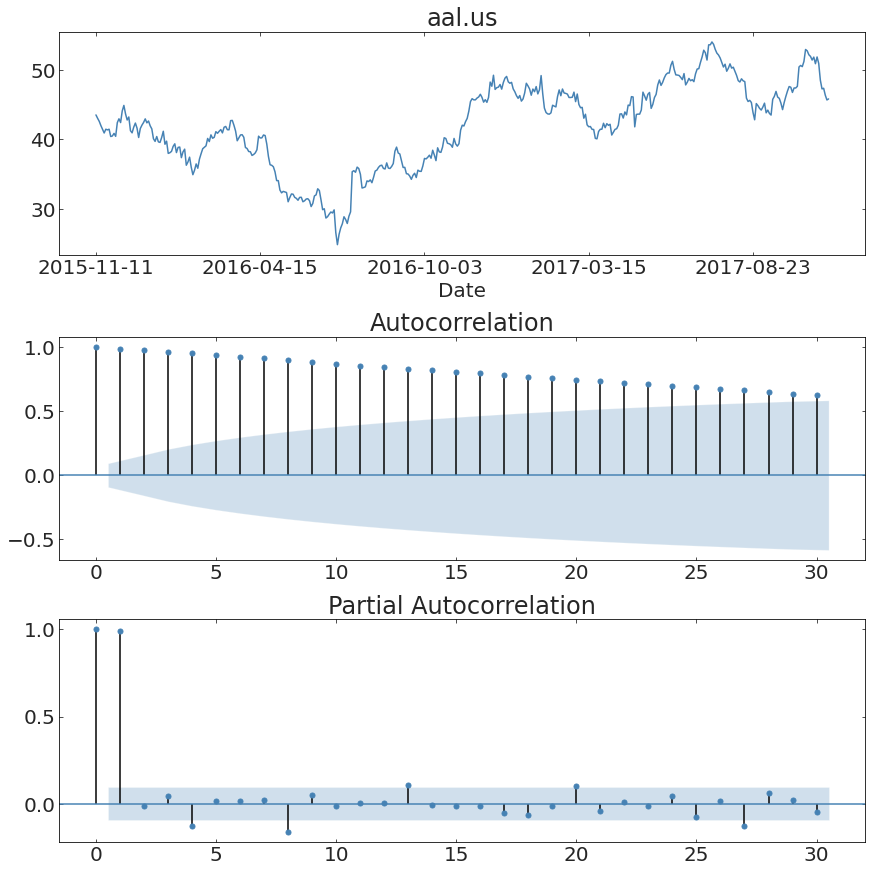

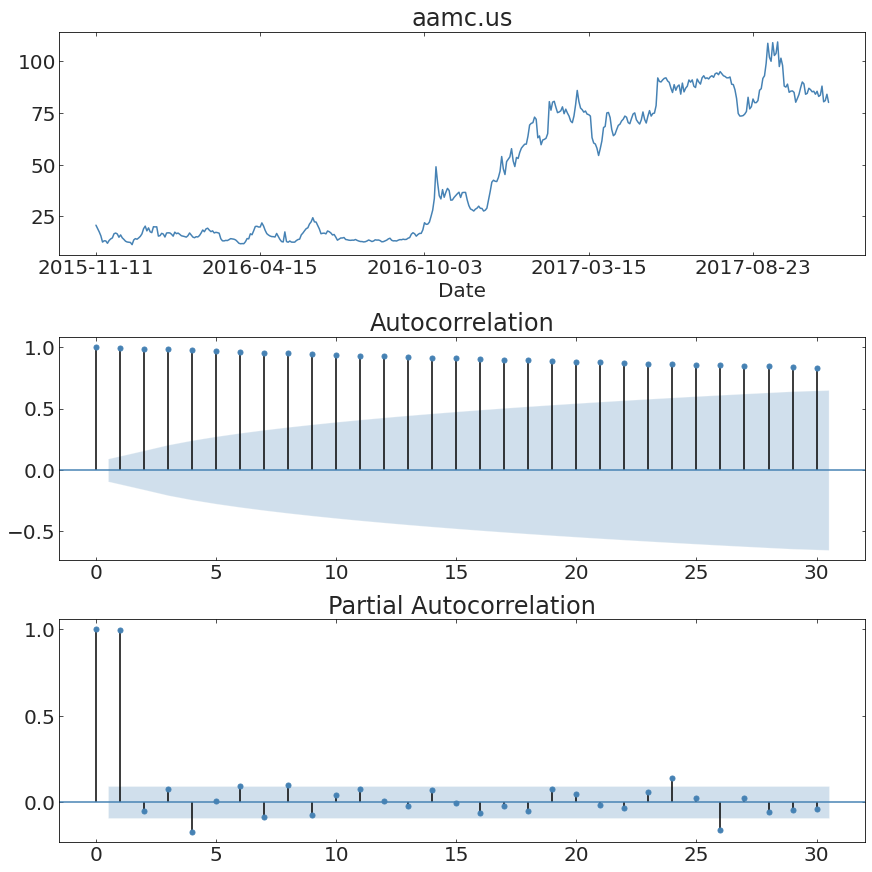

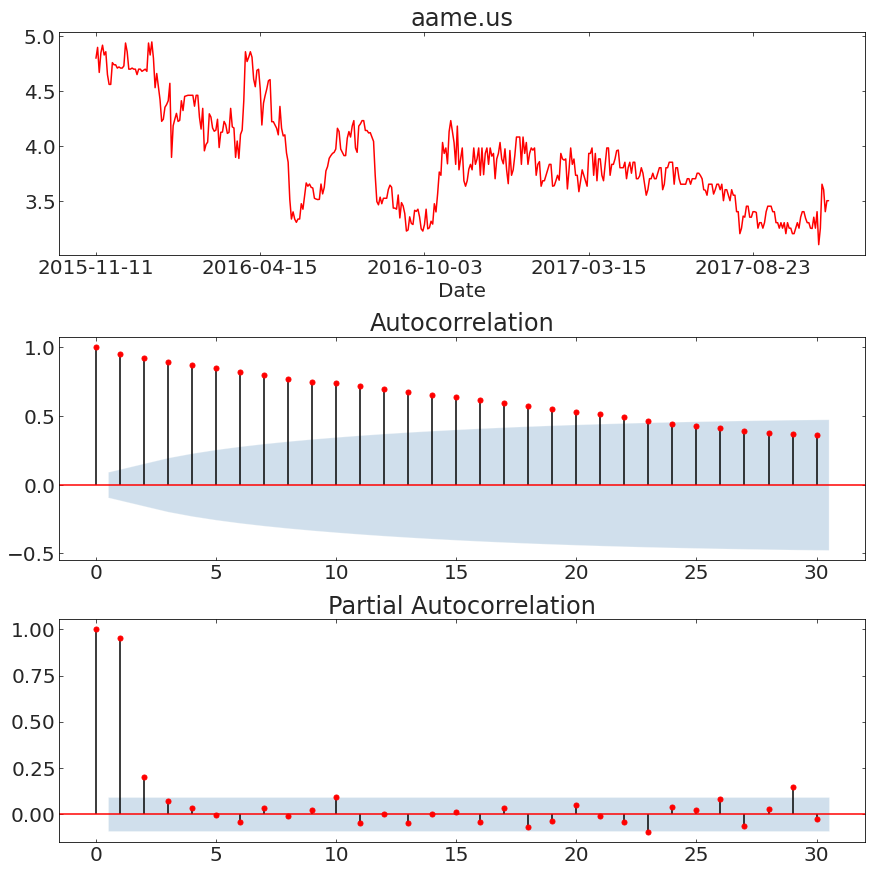

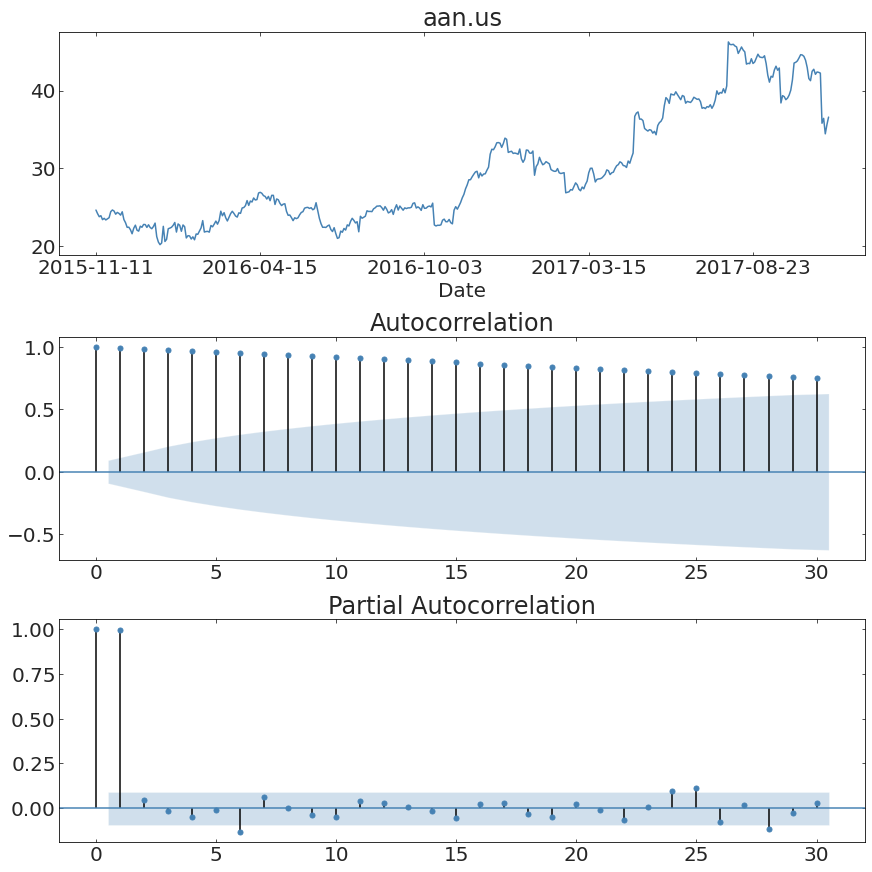

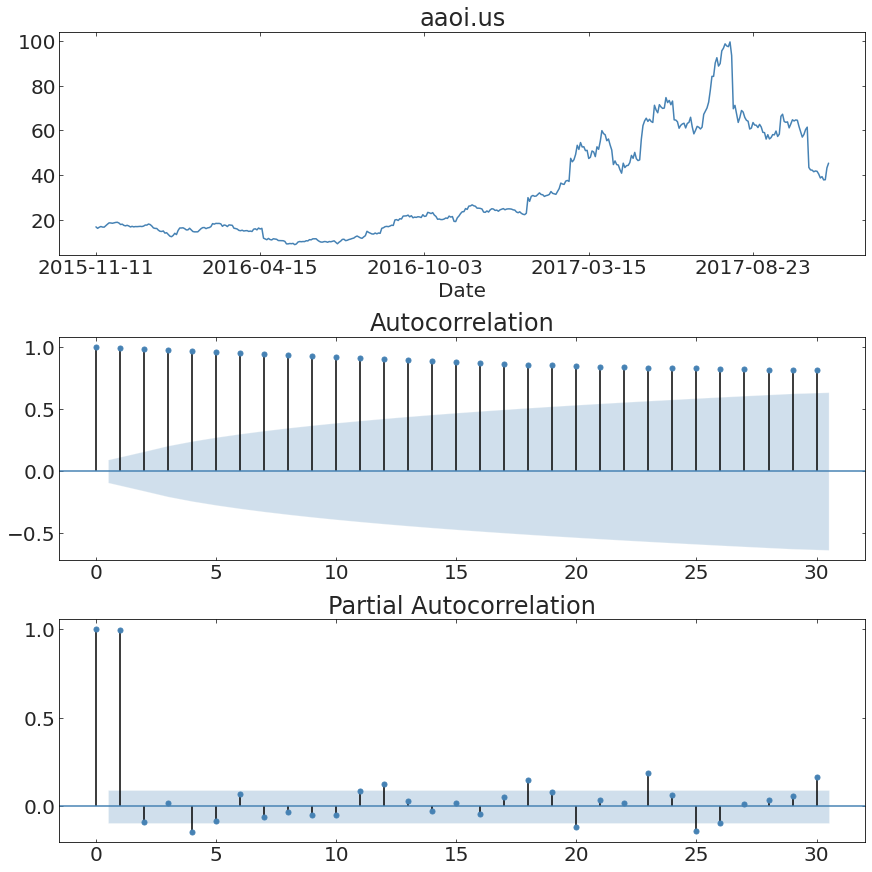

In [ ]:
for c in tss.columns:
    if sm.tsa.stattools.adfuller(tss[c])[1] < threshold: 
      fig, ax = plt.subplots(3, figsize=(12,12), constrained_layout=True)
      tss[c].plot(ax=ax[0], color="red")
      ax[0].set_title(c)
      sm.graphics.tsa.plot_acf(tss[c], lags=30, color = "red", ax=ax[1])
      sm.graphics.tsa.plot_pacf(tss[c], lags=30, color = "red", ax=ax[2])
    else:
      fig, ax = plt.subplots(3, figsize=(12,12), constrained_layout=True)
      tss[c].plot(ax=ax[0])
      ax[0].set_title(c)
      sm.graphics.tsa.plot_acf(tss[c], lags=30, ax=ax[1])
      sm.graphics.tsa.plot_pacf(tss[c], lags=30, ax=ax[2])


Fig 4: time series, autocorrelation, and partial autocorrelation plots for our ten stocks from HW2. Stock time series measured as stationary by our AD Fuller test are red, non-stationary are blue. 

<font color="red"> FBB:what do the plots actually mean? what is the shaded region? what is on the y and x axis? note that as a default statsmodels does not plot the x label here</font>

# 3. Question: pick one of the time series (of your choice) and tell me which lags are expected to be significant in the model based on the ACF and PACF plots you made

In aaap.us, around the first 23 lags would be expected to be significant in the ACF plot; in the PACF plot the second and seventh lags would be expected to be significant.

# 4. Task: training and testing split
To set up a training and test set for this, remove the last two months of data (60 days) and use it as a test set. Were your predictions good enough to make you rich? Predict 100 days forward of the training set

you do not have to overthink it and create differnt variables, you can simply select data without the last 2 month when you pass the data to the fit function. Here, make a plot of the first time series plotting in blue the training data and in orange the test data

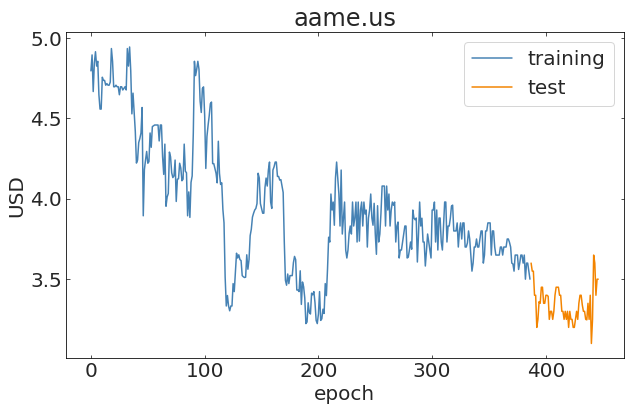

In [ ]:
pl.plot(np.arange(tss.shape[0] - 60), tss.loc[:,"aame.us"][:-60], label = "training")
pl.plot(np.arange(tss.shape[0] - 60, tss.shape[0]), tss.loc[:,"aame.us"][-60:], label="test");
pl.title("aame.us")
pl.xlabel("epoch")
pl.ylabel("USD")
pl.legend()

Fig. 5: Plot of our test and training sets from aame.us

<font color="red"> FBB:what do the colors represent?</font>

# Part 2: Model and Forecast
Here we are doing sock price analysis. The most likely reason is that we want to make $$$ - so we want to forecast the future. 


To fit the model to the data use ```statsmodels.api.tsa.ARMA```

You can inspect the function call as ```statsmodels.api.tsa.ARMA?```
The statsmodels models are generally fit into 2 phases: generating the model ```sm.tsa.ARMA(data, parameters)```, and then fitting it ```sm.tsa.ARMA(data, parameters).fit()```. 

To look at the model result, including the AIC,  look at the model summary ```mod.summary()``` What are the best fit parameters based on this printed summary and thewir uncertainties? What is the value of the AIC(Aikiki Information Criterion)

See https://github.com/fedhere/MLTSA22_FBianco/CodeExamples/ARMA/testingARMA_ARIMA.ipynb



# 5. Task: Fit one of the stationary time series with ARMA
a. Fit the model for a variety of parameters. You can run a nested loop to iterate over a range of p and q parameters. 

b. At each loop step record the AIC score for each fit. 

c. Find the best parameters to fit this time series with the AIC minimization criterion. For each model, after you fit it to the data, you can get the value of the AIC as ```model.aic```

In [ ]:
#example of model output
# mod = sm.tsa.ARMA(tss[['aame.us']], (1,1)).fit()

aics = np.zeros((5,5))
for p in range(5):
  for q in range(5):
    try:
       aics[p, q] = sm.tsa.ARMA(tss["aame.us"][:60], (p, q)).fit().aic  
    except:
      aics[p, q] = np.nan
        
print("best parameters: ", np.where(aics == np.nanmin(aics)))


#(tss[c], (3,1), dates=tss["Date"], ).fit()
#mod.plot_predict(dynamic=True, plot_insample=False)
# mod.summary()

best parameters:  (array([1]), array([1]))


In [ ]:
mod = sm.tsa.ARMA(tss[['aame.us']][:-60], (1,1)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  387
Model:                     ARMA(1, 1)   Log Likelihood                 249.303
Method:                       css-mle   S.D. of innovations              0.127
Date:                Tue, 01 Mar 2022   AIC                           -490.605
Time:                        01:55:20   BIC                           -474.772
Sample:                             0   HQIC                          -484.327
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9933      0.184     21.678      0.000       3.632       4.354
ar.L1.aame.us     0.9765      0.012     82.087      0.000       0.953       1.000
ma.L1.aame.us    -0.2624      0.052     -5.073      0.000      -0.364      -0.161
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0241           +0.0000j            1.0241            0.0000
MA.1            3.8105           +0.0000j            3.8105            0.0000
-----------------------------------------------------------------------------
"""

## 6. Task: predict the in-set (training) and the future alues

you can use ```mod.plot_predict()``` to generate and visualize the prediction at once

In [ ]:
# the lenght of the data
N = tss[['aame.us']].shape[0]


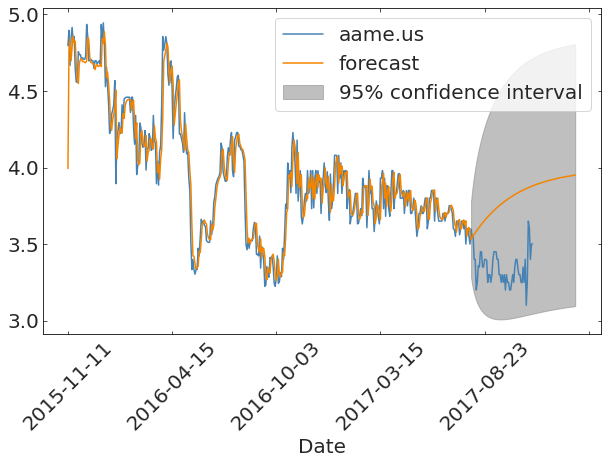

In [ ]:
ax = tss[['aame.us']].plot()

mod.plot_predict(end=N+40, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 6: Plot of aame.us timeseries with ARMA model's forecast overlaid. While the data following the training model is pretty good, the forecast diverges from the test model: it shows an upward trend while the actual aame.us data trends lower.

<font color="red"> FBB:that is a pretty good caption! - also describe the uncertainty region</font>

# 7. Question: Did you make money??
LOL nope

<font color="red"> FBB:correct</font>

In [ ]:
mod.params

const            3.993259
ar.L1.aame.us    0.976511
ma.L1.aame.us   -0.262429
dtype: float64

# 8. Question: what are the coefficients of the best fit model? what do they mean? 

The coefficients of the model are 3.993259 (constant), 0.976511 (AR) and -0.262429 (MA). These are the numbers that we'd be multiplying our variables by in the ARMA equation (if I'm being honest I don't exactly know where they fit because staring at an equation gets me nowhere). But I also think that a coefficient that's smaller than its standard deviation is probably not going to be hugely influential on my results? 

<font color="red"> FBB:this is all correct - in factnot standard deviation but standard error: if the standard error is larger than the coefficient that means the coefficient is consistent to 0 (because coefficient-std err <0 <coefficient+std err)!!</font>

#  9. Task: choose 2 non stationary time series in the set that are not correlated and repeat Tasks 5 amd 6 with the ARIMA model

choose integration 1 to start ...

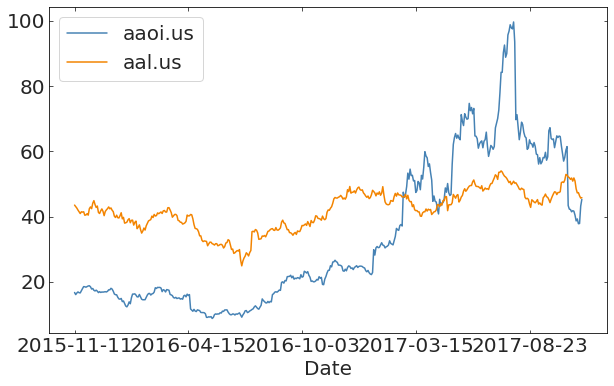

In [ ]:
ax = tss["aaoi.us"].plot()
tss["aal.us"].plot(ax=ax)
ax.legend()

Fig. 7: Plots of aaoi.us and aal.us time series. 

In [ ]:
aics = np.zeros((5,5))
def run_pq(col):
  for p in range(5):
      for q in range(5):
              try:
                  mod = sm.tsa.ARIMA(tss[col][:-60], (p,1,q)).fit()  
                  aics[p][q] = mod.aic
              except:
                  aics[p][q] = np.nan
          
  p,q = np.where(aics == np.nanmin(aics))          
  print(col+" best parameters: p: {:d} q: {:d}".format(p[0],q[0]))

run_pq("aaoi.us")
run_pq("aal.us")


aaoi.us best parameters: p: 3 q: 2
aal.us best parameters: p: 3 q: 2


In [ ]:
mod_aaoi = sm.tsa.ARIMA(tss["aaoi.us"][:-60], (3,1,2)).fit() 
mod_aal = sm.tsa.ARIMA(tss["aal.us"][:-60], (3,1,2)).fit() 

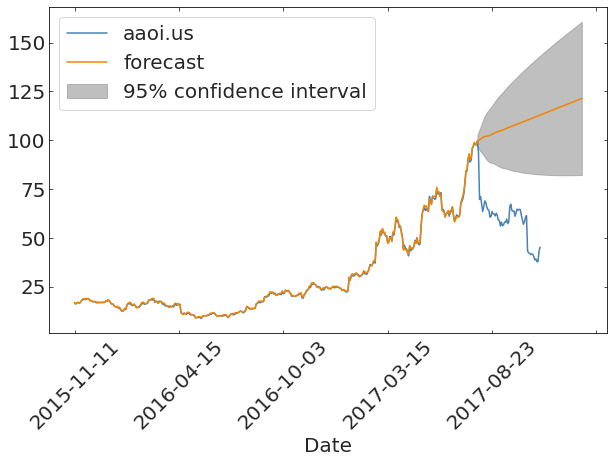

In [ ]:
ax = tss[['aaoi.us']].plot()

mod_aaoi.plot_predict(end=N+40, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 8: aaoi.us time series overlaid with ARIMA model based on aaoi.us. The model's forecast for the test data is, like aame.us, very far off from what actually happened.

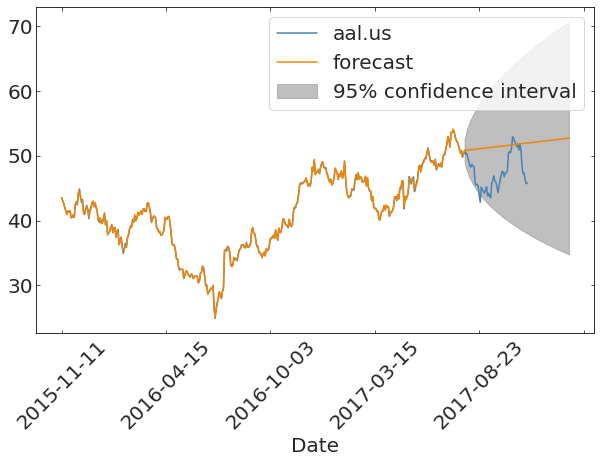

In [ ]:
ax = tss[['aal.us']].plot()

mod_aal.plot_predict(end=N+40, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 9: aal.us timeseries overlaid with ARIMA model based on aal.us. The forecast briefly converges with the test data, but ultimately diverges. 

#10. Question: Did you get rich?

With aaoi.us I for sure did not get rich, if I sold a little earlier with aal.us I might have broken even but if not I just lost money again.

# 11 Task: Redo the fit to one of the non-stsationary lightcurves with a different order of integration and compare the results. What do the coefficients tell you?

In [ ]:
mod_aal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.aal.us   No. Observations:                  386
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -508.497
Method:                       css-mle   S.D. of innovations              0.903
Date:                Tue, 01 Mar 2022   AIC                           1030.995
Time:                        01:55:31   BIC                           1058.685
Sample:                             1   HQIC                          1041.976
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0191      0.046      0.412      0.681      -0.072       0.110
ar.L1.D.aal.us    -0.4152      0.112     -3.721      0.000      -0.634      -0.196
ar.L2.D.aal.us    -0.8817      0.096     -9.231      0.000      -1.069      -0.694
ar.L3.D.aal.us     0.0511      0.059      0.867      0.387      -0.064       0.167
ma.L1.D.aal.us     0.4140      0.100      4.136      0.000       0.218       0.610
ma.L2.D.aal.us     0.8493      0.100      8.499      0.000       0.653       1.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2595           -1.0167j            1.0493           -0.2898
AR.2           -0.2595           +1.0167j            1.0493            0.2898
AR.3           17.7868           -0.0000j           17.7868           -0.0000
MA.1           -0.2437           -1.0573j            1.0851           -0.2861
MA.2           -0.2437           +1.0573j            1.0851            0.2861
-----------------------------------------------------------------------------
"""

In [ ]:
mod_aal_refit = sm.tsa.ARIMA(tss["aal.us"][:-60], (4,1,3)).fit() 
mod_aal_refit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.aal.us   No. Observations:                  386
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -509.115
Method:                       css-mle   S.D. of innovations              0.904
Date:                Tue, 01 Mar 2022   AIC                           1036.230
Time:                        01:57:46   BIC                           1071.833
Sample:                             1   HQIC                          1050.349
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0186      0.045      0.414      0.679      -0.070       0.107
ar.L1.D.aal.us     0.3597      0.191      1.879      0.061      -0.016       0.735
ar.L2.D.aal.us    -0.1678      0.230     -0.730      0.466      -0.619       0.283
ar.L3.D.aal.us    -0.6369      0.207     -3.076      0.002      -1.043      -0.231
ar.L4.D.aal.us    -0.0864      0.056     -1.554      0.121      -0.195       0.023
ma.L1.D.aal.us    -0.3669      0.187     -1.957      0.051      -0.734       0.000
ma.L2.D.aal.us     0.1230      0.210      0.586      0.558      -0.288       0.534
ma.L3.D.aal.us     0.7423      0.186      3.990      0.000       0.378       1.107
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5935           -0.8334j            1.0232           -0.1515
AR.2            0.5935           +0.8334j            1.0232            0.1515
AR.3           -1.5854           -0.0000j            1.5854           -0.5000
AR.4           -6.9697           -0.0000j            6.9697           -0.5000
MA.1            0.5758           -0.8314j            1.0113           -0.1536
MA.2            0.5758           +0.8314j            1.0113            0.1536
MA.3           -1.3173           -0.0000j            1.3173           -0.5000
-----------------------------------------------------------------------------
"""

<font color="red"> FBB:pretty good! all figures shoudl have captions and those that did described the plot correctly and sometime insightfully. except only _most_ of them had a caption :-) but good</font>